No handles with labels found to put in legend.


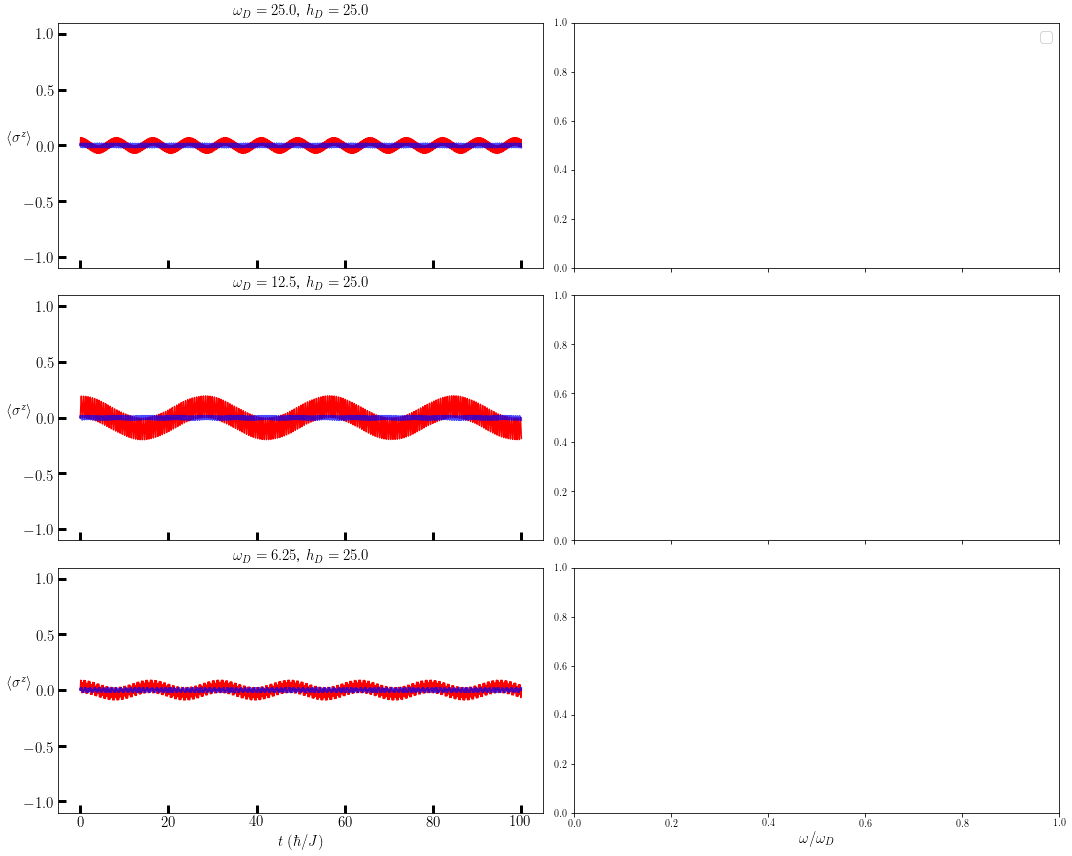

In [1]:
import numpy as np
from numpy.linalg import multi_dot, norm, eig
from odeintw import odeintw
from scipy.signal import square, find_peaks

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

fs = 15
pheightmin = 10

fig, axs = plt.subplots(3, 2, sharex='col', figsize=(15,12))

sx = np.array([[0, 1],[ 1, 0]])
sy = np.array([[0, -1j],[1j, 0]])
sz = np.array([[1, 0],[0, -1]])

t = np.linspace(0, 100, 3000)
h0 = 0.0
h = 25.0


omegas = [h, h/2.0, h/4.0]

lastplot = len(omegas) - 1

def mf_jac (psi, t, h0, h, omega):
    sx_mf = multi_dot([psi.conjugate(), sx, psi])
    #drive = h0 + h * np.cos(omega * t)
    drive = h0 + h * square(omega*t)
    jac = (1j) * (sx_mf * sx + drive * sz)
    return jac

def mf_func (psi, t, h0, h, omega):
    return np.dot(mf_jac(psi, t, h0, h, omega), psi)

def tls_jac (psi, t, h0, h, omega):
    drive = h0 + h * np.cos(omega * t)
    jac = (1j) * 0.5 * (sx + drive * sz)
    return jac

def tls_func (psi, t, h0, h, omega):
    return np.dot(tls_jac(psi, t, h0, h, omega), psi)

#Start from the t=0 ground state
#evals, evecs = eig((1j) * tls_jac(None, 0.0, h0, h, 1.0))
#psi0 = evecs[:,np.argmin(evals)].copy()

#Start from eigenstate of sx
evals, evecs = eig((1j) * tls_jac(None, 0.0, 0.0, 0.0, 0.0))
psi0 = evecs[:,np.argmin(evals)].copy()

for i, w in enumerate(omegas):
    # Set up the inputs and call odeintw to solve the system.
    sol_mf = odeintw(mf_func, psi0, t, args=(h0, h, w), Dfun=mf_jac)
    sol_tls = odeintw(tls_func, psi0, t, args=(h0, h, w), Dfun=tls_jac)
    #calculate expectation values
    mx_mf = np.einsum("ij,jk,ik->i", sol_mf.conjugate(), sx, sol_mf)
    mz_mf = np.einsum("ij,jk,ik->i", sol_mf.conjugate(), sz, sol_mf)
    mx_tls = np.einsum("ij,jk,ik->i", sol_tls.conjugate(), sx, sol_tls)
    mz_tls = np.einsum("ij,jk,ik->i", sol_tls.conjugate(), sz, sol_tls)
    
    axs[i, 0].set_title(r"$\omega_D = {}$, ".format(w) + r"$h_D = {}$ ".format(h), fontsize=fs)
    axs[i, 0].plot(t, mz_tls.real,'r', label = "TLS Soln")
    axs[i, 0].plot(t, mz_mf.real, 'b', label = "MF Soln", alpha=0.7)
    axs[i, 0].set_ylabel(r'$\langle\sigma^z\rangle$',fontsize=fs, rotation=0)
    axs[i, 0].tick_params(direction='in', length=8, width=3, labelsize=fs)
    axs[i, 0].set_yticks([-1.,-0.5,0.,0.5,1.], minor=False)
    #axs[i, 0].set_xlim(-1.1, 10.1)
    axs[i, 0].set_ylim(-1.1, 1.1)
    
    #Now, FFT
    #freqs_mf = np.fft.fftshift(np.fft.fftfreq(np.size(mz_mf), d=t[1]-t[0]))
    #spectrum_mf = np.fft.fftshift(np.fft.fft(mz_mf - np.average(mz_mf)))
    #freqs_tls = np.fft.fftshift(np.fft.fftfreq(np.size(mz_tls), d=t[1]-t[0]))
    #spectrum_tls = np.fft.fftshift(np.fft.fft(mz_tls - np.average(mz_tls)))
    #axs[i, 1].set_ylabel(r'$S^z_\omega$',fontsize=fs, rotation=0)
    #axs[i, 1].tick_params(direction='in', length=8, width=3, labelsize=fs)
    #axs[i, 1].plot(2.0 * np.pi * freqs_tls.real/w, np.abs(spectrum_tls),'r', label = "TLS Soln")
    #axs[i, 1].plot(2.0 * np.pi * freqs_mf.real/w, np.abs(spectrum_mf),'b', label = "MF Soln", alpha=0.6)
    #peaks, _ = find_peaks(np.abs(spectrum_mf), height=pheightmin)
    #axs[i, 1].plot(2.0 * np.pi * freqs_mf[peaks].real/w, np.abs(spectrum_mf[peaks]), "x", label = "MF Peaks", alpha=0.6)
    #axs[i, 1].set_yscale('log')
    #axs[i, 1].set_ylim(0.001, 5000)
    #axs[i, 1].set_xlim(-0.01, 1.48)


axs[lastplot, 0].set_xlabel(r'$t\;(\hbar/J)$',fontsize=fs)    
axs[lastplot, 1].set_xlabel(r'$\omega/\omega_D$',fontsize=fs)

legend0 = axs[0, 1].legend(prop={'size': fs})

# Norm sanity check
#plt.plot(t, np.abs(sol_mf[:, 0])**2 + np.abs(sol_mf[:, 1])**2)
fig.tight_layout()

### Detailed investigation of 'freezing' in the Parameter Space

We now look at plots of $S^m_\omega$, the  maximum peak height in the FFT of the time signal, as function of $\omega_D$. The code below (self expanatory) does just this. Note that $S^m_\omega$ has a highly non-monotonic dependence for the MF dynamics (left panel below) and approaches a small minimum (nearly $0$) for a discrete set of values of, signifying a freeze of the system in its initial state. Thus, we can infer that this resonance occurs at multiiple values of $\omega$ for every $h_D$. The positions of these minima are quantitatively different for the TLS dynamics (right panel below), where they occur, as expected from the RWA analysis described above, at the zeroes of $J_0(\eta)$, as can be seen from the plot on the rightmost ordinate below.

TLS dynamics for h = 25.000000, w with 12 processes ...
Done in 683.812917 secs
MF dynamics for h = 25.000000, w with 12 processes ...
Done in 1864.610734 secs
TLS dynamics for h = 50.000000, w with 12 processes ...
Done in 867.641391 secs
MF dynamics for h = 50.000000, w with 12 processes ...
Done in 2680.171057 secs
TLS dynamics for h = 75.000000, w with 12 processes ...
Done in 1053.775577 secs
MF dynamics for h = 75.000000, w with 12 processes ...


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


Done in 3442.185746 secs


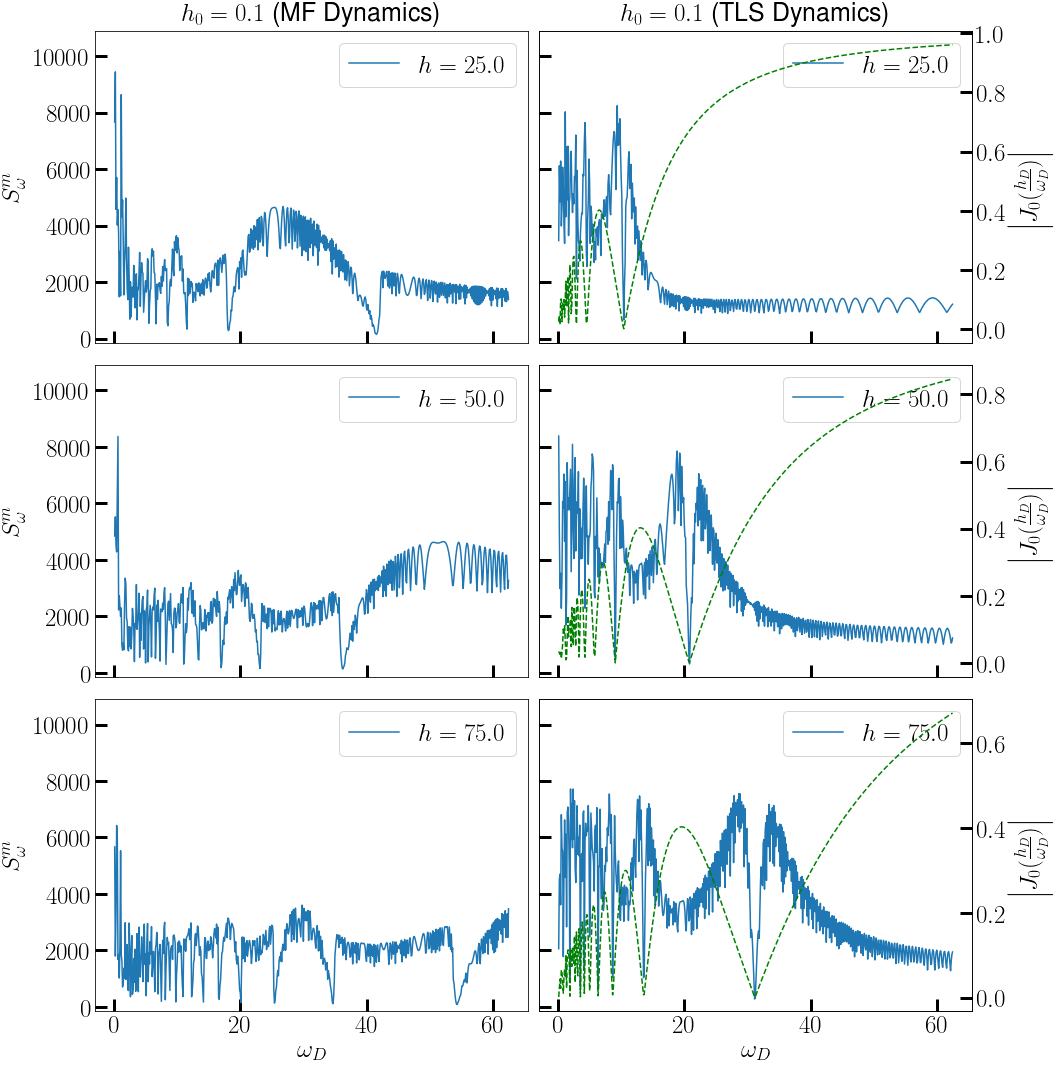

In [17]:
import numpy as np
from numpy.linalg import norm, eig
from multiprocessing import Pool
import time
from scipy.special import j0

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

def maxfft_mag_mf(t, psi0, h0, h, omega):
    sol_mf = odeintw(mf_func, psi0, t, args=(h0, h, omega), Dfun=mf_jac)
    #calculate expectation values
    mz_mf = np.einsum("ij,jk,ik->i", sol_mf.conjugate(), sz, sol_mf)
    spectrum_mf = np.fft.fftshift(np.fft.fft(mz_mf - np.average(mz_mf)))
    peaks, _ = find_peaks(np.abs(spectrum_mf), height=pheightmin)
    return np.amax(np.abs(spectrum_mf[peaks]))
    
def maxfft_mag_tls(t, psi0, h0, h, omega):
    sol_tls = odeintw(tls_func, psi0, t, args=(h0, h, omega), Dfun=tls_jac)
    #calculate expectation values
    mz_tls = np.einsum("ij,jk,ik->i", sol_tls.conjugate(), sz, sol_tls)
    spectrum_tls = np.fft.fftshift(np.fft.fft(mz_tls - np.average(mz_tls)))
    peaks, _ = find_peaks(np.abs(spectrum_tls), height=pheightmin)
    return np.amax(np.abs(spectrum_tls[peaks]))


if __name__ == '__main__':
    nprocs = 12
    evals, evecs = eig((1j) * tls_jac(None, 0.0, 0.0, 0.0, 0.0))
    psi0 = evecs[:,np.argmin(evals)].copy()
    amps = [25.0, 50.0, 75.0]
    h0 = 0.1
    omegas = np.linspace(0.1, 2.5 * h,  50 * nprocs)
    
    t = np.linspace(0, 1000, 30000)
    p = Pool(processes = nprocs)
    
    fs = 25
    threshold = 130.0
    
    fig, axs = plt.subplots(3, 2, sharey=True, figsize=(15,15))
    
                
    for i, h in enumerate(amps):
        ## Internal Execution
        print("TLS dynamics for h = %f, w with %d processes ..." % (h, nprocs))
        start = time.time()
        dq_tls = p.starmap(maxfft_mag_tls,[(t, psi0, h0, h, w) for w in omegas])
        elapsed =  (time.time() - start)
        print("Done in %lf secs" % elapsed)
        print("MF dynamics for h = %f, w with %d processes ..." % (h, nprocs))
        start = time.time()
        dq_mf = p.starmap(maxfft_mag_mf,[(t, psi0, h0, h, w) for w in omegas])
        elapsed = (time.time() - start)  
        print("Done in %lf secs" % elapsed)
  
        ## Load from external execution
        #fname = "mf_tls_driven_hd_25.0_h0_0.1_pheight.csv"
        #data = np.loadtxt(fname, delimiter=",")
        #omegas = data[:,0]
        #dq_mf = data[:,1]
        #dq_tls = data[:,2]
        axs[i, 0].set_ylabel(r'$S^m_\omega$',fontsize=fs, rotation="vertical")


        axs[i, 0].plot(omegas, dq_mf, label = r'$h = {}$ '.format(h))
        legend0 = axs[i, 0].legend(prop={'size': fs})
        axs[i,1].plot(omegas, dq_tls, label = r'$h = {}$ '.format(h))
        legend1 = axs[i, 1].legend(prop={'size': fs})
        ax_besj = axs[i, 1].twinx()
        ax_besj.set_ylabel(r"$\left | J_0(\frac{h_D}{\omega_D})\right |$",fontsize=fs)
        ax_besj.plot(omegas, np.abs(j0(h/omegas)), "g--")
        ax_besj.tick_params(direction='in', length=12, width=3, labelsize=fs)
    
    
    for ax in axs.flat:
        ax.tick_params(direction='in', length=12, width=3, labelsize=fs, labelbottom=False)
        ax.set_ylim(-150, 10910)
    
    for ax in axs[-1]:
        ax.set_xlabel(r'$\omega_D$',fontsize=fs)
        ax.tick_params(labelbottom=True)
        
    axs[0, 0].set_title(r"$h_0 = {}$ (MF Dynamics)".format(h0), fontsize=fs)
    axs[0, 1].set_title(r"$h_0 = {}$ (TLS Dynamics)".format(h0), fontsize=fs)
    fig.tight_layout()
    plt.plot()

## References
1. Lipkin, H. J., N. Meshkov, and A. J. Glick. “Validity of Many-Body Approximation Methods for a Solvable Model: (I). Exact Solutions and Perturbation Theory.” Nuclear Physics 62, no. 2 (February 1, 1965): 188–98. https://doi.org/10/fpqf4q.
2. Mori, T. “[1810.01584] Prethermalization in the Transverse-Field Ising Chain with Long-Range Interactions.” Accessed October 30, 2019. https://arxiv.org/abs/1810.01584.
3. Miao, Qiang, and Yujun Zheng. “Coherent Destruction of Tunneling in Two-Level System Driven across Avoided Crossing via Photon Statistics.” Scientific Reports 6, no. 1 (June 29, 2016): 1–12. https://doi.org/10.1038/srep28959.
4. Das, Arnab. “Exotic Freezing of Response in a Quantum Many-Body System.” Phys. Rev. B 82, no. 17 (November 2010): 172402. https://doi.org/10.1103/PhysRevB.82.172402.
5. Hegde, Swathi S., Hemant Katiyar, T. S. Mahesh, and Arnab Das. “Freezing a Quantum Magnet by Repeated Quantum Interference: An Experimental Realization.” Physical Review B 90, no. 17 (November 7, 2014): 174407. https://doi.org/10.1103/PhysRevB.90.174407.
6. Roy, Analabha, and Arnab Das. “Fate of Dynamical Many-Body Localization in the Presence of Disorder.” Physical Review B 91 (2015): 121106. https://doi.org/10/gcz8z2.

 7. Schachenmayer J., Pikovski A., Rey A.M. "Many-Body Quantum Spin Dynamics with Monte Carlo Trajectories on a Discrete Phase Space", Phys. Rev. X 5, 011022 (2015), https://doi.org/10.1103/PhysRevX.5.011022 .
 8. Lorenzo Pucci, Analabha Roy, and Michael Kastner, "Simulation of quantum spin dynamics by phase space sampling of Bogoliubov-Born-Green-Kirkwood-Yvon trajectories", Phys. Rev. B 93, 174302 (2016). https://doi.org/10.1103/PhysRevB.93.174302 .
 9. Asmi Haldar and Arnab Das, "Dynamical many‐body localization and delocalization in periodically driven closed quantum systems", Annalen der Physik 529(7), 1600333 (2017), https://doi.org/10.1002/andp.201600333
 10. S. Jaschke1 *et. al.*, "Critical phenomena and Kibble–Zurek scaling in the long-range quantum Ising chain", NJP 19 (2017), https://dx.doi.org/10.1088/1367-2630/aa65bc
 11. S. Susuki *et. al.*, "Quantum Ising Phases and Transitions in Transverse Ising Models", Springer (2013), https://dx.doi.org/10.1007/978-3-642-33039-1